In [1]:
from moment_analysis import ModelsContainer
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
train = 7000
val = 2000
test = 1000
X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3]
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

    

In [3]:
X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

In [4]:
num_models_to_train = 1 ##number of models to use to make error bars
order_list = [1,2,3,4] #
input_dim = 2
### specify the thing to vary ####
num_points = 3
max_L_per_order = [300,50,9,6]
L_list = [np.linspace(1,x, num_points, dtype=int) for x in max_L_per_order]
F_width = np.linspace(10,150, num_points, dtype=int)
Phi_width = np.linspace(10,150, num_points, dtype=int)
order_configs = dict()
for p, order in enumerate(order_list):
    order_configs['order'+str(order)] = [[[[] for i in range(num_points)] for i in range(num_points)] for i in range(num_points)]
    for i, L in enumerate(L_list[p]):
        for j, F in enumerate(F_width):
            for k, Phi in enumerate(Phi_width):
                order_configs['order'+str(order)][i][j][k] = [L, F, Phi]
    order_configs['order'+str(order)] = np.array(order_configs['order'+str(order)])

In [6]:

## training
epochs = 1
batch_size=500
callbacks =None
verbose = 1
###########

order_performance = dict()
for order in order_list:
    order_performance['order'+str(order)] = [[[[] for i in range(num_points)] for i in range(num_points)] for i in range(num_points)]


for order in order_list:
    info = order_configs['order'+str(order)]
    for i in range(num_points):
        for j in range(num_points):
            for k in range(num_points):
                config_info = info[i,j,k]
                L = config_info[0]
                F = config_info[1]
                Phi = config_info[2]
                container = ModelsContainer(**{'Phi_mapping_dim' : [input_dim,L],
                                      'output_dim' : 1, 'output_act' : 'sigmoid',
                                      'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU',
                                      'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU',
                                      'order' : order , 'architecture_type':'moment',
                                      'loss': 'binary_crossentropy','metrics': 'acc'})

                container.train_models(num_models = num_models_to_train,
                                           X_train = X_train, Y_train = Y_train,
                                           epochs = epochs, batch_size = batch_size,
                                           validation_data = (X_val, Y_val),
                                           callbacks=None, verbose=verbose)
                mean, std = container.test_meanstd(X_test = X_test, Y_test = Y_test, metric_function = roc_auc_score)
                num_params = container.num_params
                
                order_performance['order'+str(order)][i][j][k] = [num_params,mean,std]
    order_performance['order'+str(order)] = np.array(order_performance['order'+str(order)])

14/14 [==============================] - 2s 42ms/step - loss: 0.6916 - acc: 0.5339 - val_loss: 0.6806 - val_acc: 0.6355


14/14 [==============================] - 3s 59ms/step - loss: 0.6729 - acc: 0.6196 - val_loss: 0.6426 - val_acc: 0.6525


In [32]:
file_to_save = {'configs' : order_configs, 'performance' : order_performance}
np.save('datapoints', file_to_save)

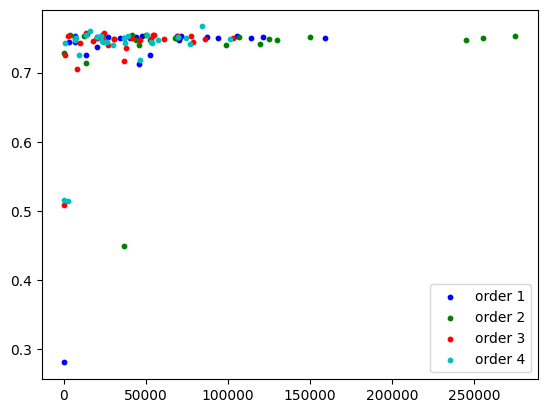

In [21]:
import matplotlib.pyplot as plt
colors = 'bgrcmk'
fig, axes = plt.subplots(1, 1)
for p, order in enumerate(order_list):
    x = []
    y = []
    yerr= []
    for i in range(num_points):
        for j in range(num_points):
            for k in range(num_points):

                datapoint = order_performance['order'+str(order)][i][j][k]
                x.append(datapoint[0])
                y.append(datapoint[1])
                yerr.append(datapoint[2])
    axes.scatter(x, y, s=10, c=colors[p], label = 'order '+str(order))
    axes.errorbar(x,y, yerr, c=colors[p], linestyle='None')
axes.legend()
plt.show()